In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

## Espacios Públicos GDL

In [2]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf_gdl = aup.gdf_from_db(table,schema)

In [3]:
gdf_gdl.shape

(8499, 4)

## Espacios Públicos QRO

In [4]:
schema = 'espacios_publicos'
table = 'ep_qro'
gdf_qro = aup.gdf_from_db(table,schema)

In [5]:
gdf_qro.shape

(4814, 9)

## Espacios Públicos CDMX

In [6]:
schema = 'espacios_publicos'
table = 'ep_cdmx'
gdf_cdmx = aup.gdf_from_db(table,schema)

In [7]:
gdf_cdmx.shape

(11609, 13)

## Juntamos en un dataset

In [8]:
gdf_gdl = gdf_gdl.set_crs("EPSG:4326", allow_override=True)
gdf_qro = gdf_qro.set_crs("EPSG:4326", allow_override=True)
gdf_cdmx = gdf_cdmx.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)
print("CRS of gdf_qro:", gdf_qro.crs)
print("CRS of gdf_cdmx:", gdf_cdmx.crs)

CRS of gdf_gdl: EPSG:4326
CRS of gdf_qro: EPSG:4326
CRS of gdf_cdmx: EPSG:4326


In [9]:
geodataframes = [gdf_gdl, gdf_qro, gdf_cdmx]
gdf = pd.concat(geodataframes)
gdf = gdf['geometry']
gdf.head()

0    POLYGON ((672507.02800 2272132.20130, 672520.1...
1    POLYGON ((672520.12560 2272170.35300, 672507.0...
2    POLYGON ((672494.32530 2272095.20510, 672480.3...
3    POLYGON ((672480.36630 2272060.73140, 672494.3...
4    POLYGON ((672468.71720 2272020.61270, 672456.8...
Name: geometry, dtype: geometry

In [10]:
gdf.shape

(24922,)

## Hexágonos 3 ciudades

In [11]:
hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
hex_table_tempt = "temperature_analysis_hex"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Querétaro'
n = '11'
query = f"""
SELECT h1.hex_id, h1.geometry, h1.city 
FROM {hex_schema}.{hex_table} h1
JOIN {hex_schema}.{hex_table_tempt} h2
ON h1.hex_id = h2.hex_id
WHERE h1.city IN ('{c1}', '{c2}') AND h1.res = {n}
"""
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdl.head(5)

,hex_id,geometry,city
0,8b4995b84985fff,"POLYGON ((-99.14725 19.42254, -99.14707 19.422...",CDMX
1,8b4995b8051afff,"POLYGON ((-99.13234 19.45502, -99.13216 19.455...",CDMX
2,8b4995b80571fff,"POLYGON ((-99.13590 19.45491, -99.13573 19.455...",CDMX
3,8b4995b80494fff,"POLYGON ((-99.12840 19.45801, -99.12822 19.458...",CDMX
4,8b4995b80446fff,"POLYGON ((-99.13540 19.45875, -99.13522 19.458...",CDMX


In [12]:
hex_gdl.shape

(807653, 3)

In [13]:
hex_gdl['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [14]:
contador_gdll = np.sum(hex_gdl['city'] == 'Guadalajara')
contador_cdmxx = np.sum(hex_gdl['city'] == 'CDMX')
#contador_qroo = np.sum(hex_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdll} \nNúmero de hexágonos Cdmx: {contador_cdmxx}')

Número de hexágonos Gdl: 445881 
Número de hexágonos Cdmx: 361772


In [15]:
hex_gdl = hex_gdl.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)

CRS of gdf_gdl: EPSG:4326


Como tenemos 807,653 hexágonos tenemos que reducir la dimensión a 400,000 porque mi compu no puede con tantos datos. Vamos a reducir la dimensión de las 3 ciudades a la mitad. Inicialmente, tenemos que Guadalajara tiene 400,000 hexágonos. Cdmx tiene 300,000 hexágonos y Querétaro tiene 100,000 hexágonos. Pero después de reducir las dimensiones serán 200,000; 150,000 y 50,000 respectivamente.

In [16]:
gdl_samples = 200000
cdmx_samples = 150000
#qro_samples = 50000

# Randomly sample 200,000 hexagons of Guadalajra
sample_with_Guadalajara = hex_gdl[hex_gdl['city'] == 'Guadalajara'].sample(n=gdl_samples, random_state=42)

# Randomly sample 150,000 hexagons of Cdmx
sample_with_Cdmx = hex_gdl[hex_gdl['city'] == 'CDMX'].sample(n=cdmx_samples, random_state=42)

# Randomly sample 50,000 hexagons of Queretaro
#sample_with_Queretaro = hex_gdl[hex_gdl['city'] == 'Queretaro'].sample(n=qro_samples, random_state=42)

# Concatenate the two samples to get the final subsample
hex_gdf = pd.concat([sample_with_Guadalajara, sample_with_Cdmx]) #sample_with_Queretaro])
hex_gdf.reset_index(drop = True, inplace = True)
hex_gdf.head()

,hex_id,geometry,city
0,8b49ab5820a4fff,"POLYGON ((-103.44695 20.62709, -103.44677 20.6...",Guadalajara
1,8b49ab5a6b8afff,"POLYGON ((-103.48689 20.54403, -103.48671 20.5...",Guadalajara
2,8b498c948c6dfff,"POLYGON ((-103.34882 20.73356, -103.34864 20.7...",Guadalajara
3,8b498c96c775fff,"POLYGON ((-103.37897 20.66320, -103.37879 20.6...",Guadalajara
4,8b498c975c90fff,"POLYGON ((-103.28391 20.62076, -103.28373 20.6...",Guadalajara


In [17]:
contador_gdl = np.sum(hex_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(hex_gdf['city'] == 'CDMX')
#contador_qro = np.sum(hex_gdf['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 200000 
Número de hexágonos Cdmx: 150000


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [18]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl.head()

,hex_id,geometry,city,EspPublico
0,8b4995b84985fff,"POLYGON ((-99.14725 19.42254, -99.14707 19.422...",CDMX,0
1,8b4995b8051afff,"POLYGON ((-99.13234 19.45502, -99.13216 19.455...",CDMX,0
2,8b4995b80571fff,"POLYGON ((-99.13590 19.45491, -99.13573 19.455...",CDMX,0
3,8b4995b80494fff,"POLYGON ((-99.12840 19.45801, -99.12822 19.458...",CDMX,1
4,8b4995b80446fff,"POLYGON ((-99.13540 19.45875, -99.13522 19.458...",CDMX,0


In [19]:
contador_ceros = np.sum(hex_gdl['EspPublico'] == 0)
contador_uno = np.sum(hex_gdl['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 708008 
Número de Hexágonos con Espacios Públicos: 99645
Número total de Hexágonos: 807653


## Hexágonos con info de humedad, vegetación y temperatura

select {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.ndmi_analysis_hex ndmi

inner join raster_analysis.ndvi_analysis_hex ndvi

on ndmi.hex_id = ndvi.hex_id 

where ndmi.city  in ('Queretaro','Guadalajara','ZMVM') and ndmi.res = 11

In [20]:
import psycopg2

#Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

#Ejecutar la consulta para obtener los nombres de las columnas
cur.execute("""
    SELECT column_name 
    FROM information_schema.columns 
    WHERE table_schema = 'raster_analysis' 
    AND table_name = 'temperature_analysis_hex';
""")

#Obtener los resultados
columns = cur.fetchall()

#Imprimir los nombres de las columnas
for column in columns:
    print(column[0])

cur.close()
conn.close()

hex_id
geometry
res
temperature_mean
temperature_std
temperature_median
temperature_max
temperature_min
temperature_diff
temperature_tend
city
temp_diff_mean


In [21]:
import psycopg2

#Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

#Ejecutar la consulta para obtener los nombres de las columnas
cur.execute("""
    SELECT column_name 
    FROM information_schema.columns 
    WHERE table_schema = 'raster_analysis' 
    AND table_name = 'ndvi_analysis_hex';
""")

#Obtener los resultados
columns = cur.fetchall()

#Imprimir los nombres de las columnas
for column in columns:
    print(column[0])

cur.close()
conn.close()

hex_id
geometry
res
ndvi_mean
ndvi_std
ndvi_median
ndvi_max
ndvi_min
ndvi_diff
ndvi_tend
city


In [22]:
hex_schema = "raster_analysis"
hex_schema_pob = "hexgrid"
hex_tablee = "ndvi_analysis_hex"
hex_table = "ndmi_analysis_hex"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_tempt = "temperature_analysis_hex"
ndmi = "ndmi"
ndvi = "ndvi"
temp = "temp"
poblation = "POBTOT"
hex_id = "hex_id"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Queretaro'
n = '11'

query = f'''
SELECT 
    temp.hex_id, 
    temp.city, 
    temp.geometry AS geometry,  
    temp.res AS temp_res,
    ndmi.geometry AS ndmi_geometry, 
    ndmi.city AS ndmi_city, 
    ndmi.res AS ndmi_res, 
    ndvi.geometry AS ndvi_geometry, 
    ndvi.city AS ndvi_city, 
    ndvi.res AS ndvi_res, 
    ndvi.ndvi_mean, 
    ndvi.ndvi_std, 
    ndvi.ndvi_median, 
    ndvi.ndvi_max, 
    ndvi.ndvi_min, 
    ndvi.ndvi_diff, 
    ndvi.ndvi_tend,
    ndmi.ndmi_mean, 
    ndmi.ndmi_median, 
    ndmi.ndmi_diff, 
    temp.temp_diff_mean
FROM 
    {hex_schema}.{hex_table_tempt} temp  
INNER JOIN 
    {hex_schema}.{hex_table} ndmi 
    ON temp.hex_id = ndmi.hex_id
INNER JOIN 
    {hex_schema}.{hex_tablee} ndvi 
    ON ndmi.hex_id = ndvi.hex_id
WHERE 
    temp.city IN ('{c1}', '{c2}') 
    AND temp.res = {n}
'''

intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b499584eccefff,CDMX,"POLYGON ((-99.17540 19.32601, -99.17522 19.326...",11,0103000020E61000000100000007000000D9065FC639CB...,CDMX,11,0103000020E61000000100000007000000D9065FC639CB...,CDMX,11,...,0.095487,0.390565,0.429531,0.303657,0.125874,-0.003642,0.020281,0.030315,0.060107,-1.267672
1,8b4995b8ece4fff,CDMX,"POLYGON ((-99.15416 19.48823, -99.15398 19.488...",11,0103000020E6100000010000000700000094DA95AEDDC9...,CDMX,11,0103000020E6100000010000000700000094DA95AEDDC9...,CDMX,11,...,0.050015,0.115932,0.173202,0.103599,0.069603,-0.000114,-0.033794,-0.029808,0.065786,2.526792
2,8b4995b8ed56fff,CDMX,"POLYGON ((-99.15547 19.48496, -99.15529 19.485...",11,0103000020E610000001000000070000000420C93CF3C9...,CDMX,11,0103000020E610000001000000070000000420C93CF3C9...,CDMX,11,...,0.010948,-0.015257,0.000551,-0.029914,0.030465,0.000041,-0.042728,-0.042236,0.018798,3.232521
3,8b4995b8cd9efff,CDMX,"POLYGON ((-99.17308 19.47587, -99.17290 19.476...",11,0103000020E61000000100000007000000594FB2AD13CB...,CDMX,11,0103000020E61000000100000007000000594FB2AD13CB...,CDMX,11,...,0.011762,-0.019756,0.001583,-0.033220,0.034803,-0.000038,-0.125755,-0.123152,0.055054,0.168092
4,8b4995b81304fff,CDMX,"POLYGON ((-99.16801 19.47388, -99.16784 19.474...",11,0103000020E61000000100000007000000D3D59CBDC0CA...,CDMX,11,0103000020E61000000100000007000000D3D59CBDC0CA...,CDMX,11,...,0.011835,0.038702,0.047788,0.029193,0.018595,-0.000415,-0.039338,-0.040409,0.023264,3.573956
5,8b4995b138a1fff,CDMX,"POLYGON ((-99.23615 19.41072, -99.23597 19.410...",11,0103000020E61000000100000007000000F6D7A6081DCF...,CDMX,11,0103000020E61000000100000007000000F6D7A6081DCF...,CDMX,11,...,0.064977,0.305529,0.311444,0.248205,0.063239,-0.002394,0.011068,0.013627,0.035536,-0.927933
6,8b4995b10516fff,CDMX,"POLYGON ((-99.22662 19.39196, -99.22644 19.392...",11,0103000020E6100000010000000700000030DF8CF780CE...,CDMX,11,0103000020E6100000010000000700000030DF8CF780CE...,CDMX,11,...,0.116900,0.347796,0.471841,0.255304,0.216537,-0.003523,0.026187,0.028980,0.150125,-5.824248
7,8b4995b1422cfff,CDMX,"POLYGON ((-99.24706 19.37805, -99.24688 19.378...",11,0103000020E61000000100000007000000710CD1CFCFCF...,CDMX,11,0103000020E61000000100000007000000710CD1CFCFCF...,CDMX,11,...,0.137042,0.405228,0.583090,0.269271,0.313819,-0.003048,0.037727,0.043151,0.193515,-1.092825
8,8b4995b10cacfff,CDMX,"POLYGON ((-99.23022 19.38820, -99.23004 19.388...",11,0103000020E610000001000000070000007FD9F7DABBCE...,CDMX,11,0103000020E610000001000000070000007FD9F7DABBCE...,CDMX,11,...,0.093020,0.254751,0.326157,0.176948,0.149210,-0.003328,-0.016259,-0.002647,0.172510,-2.628285
9,8b4995b100eefff,CDMX,"POLYGON ((-99.23784 19.39776, -99.23766 19.397...",11,0103000020E61000000100000007000000D201C9BA38CF...,CDMX,11,0103000020E61000000100000007000000D201C9BA38CF...,CDMX,11,...,0.061181,0.340380,0.335717,0.278116,0.057601,-0.002209,0.045081,0.045895,0.026608,-1.964873


In [23]:
intt_gdl.shape

(807653, 21)

In [24]:
intt_gdl['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [25]:
intt_gdll = np.sum(intt_gdl['city'] == 'Guadalajara')
intt_cdmxx = np.sum(intt_gdl['city'] == 'CDMX')
#intt_qroo = np.sum(intt_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {intt_gdll} \nNúmero de hexágonos Cdmx: {intt_cdmxx}')

Número de hexágonos Gdl: 445881 
Número de hexágonos Cdmx: 361772


Como tenemos 800,000 hexágonos tenemos que reducir la dimensión a 400,000 porque mi compu no puede con tantos datos. Vamos a reducir la dimensión de las 3 ciudades a la mitad. Inicialmente, tenemos que Guadalajara tiene 400,000 hexágonos. Cdmx tiene 300,000 hexágonos y Querétaro tiene 100,000 hexágonos. Pero después de reducir las dimensiones serán 200,000; 150,000 y 50,000 respectivamente.

In [26]:
'''gdl_samples_int = 200000
cdmx_samples_int = 150000
qro_samples_int = 50000

# Randomly sample 200,000 hexagons of Guadalajra
sample_with_Guadalajara = intt_gdl[intt_gdl['city'] == 'Guadalajara'].sample(n=gdl_samples_int, random_state=42)

# Randomly sample 150,000 hexagons of Cdmx
sample_with_Cdmx = intt_gdl[intt_gdl['city'] == 'CDMX'].sample(n=cdmx_samples_int, random_state=42)

# Randomly sample 50,000 hexagons of Queretaro
sample_with_Queretaro = intt_gdl[intt_gdl['city'] == 'Queretaro'].sample(n=qro_samples_int, random_state=42)

# Concatenate the two samples to get the final subsample
int_gdf = pd.concat([sample_with_Guadalajara, sample_with_Cdmx, sample_with_Queretaro])
int_gdf.reset_index(drop = True, inplace = True)
int_gdf.head()'''

"gdl_samples_int = 200000\ncdmx_samples_int = 150000\nqro_samples_int = 50000\n\n# Randomly sample 200,000 hexagons of Guadalajra\nsample_with_Guadalajara = intt_gdl[intt_gdl['city'] == 'Guadalajara'].sample(n=gdl_samples_int, random_state=42)\n\n# Randomly sample 150,000 hexagons of Cdmx\nsample_with_Cdmx = intt_gdl[intt_gdl['city'] == 'CDMX'].sample(n=cdmx_samples_int, random_state=42)\n\n# Randomly sample 50,000 hexagons of Queretaro\nsample_with_Queretaro = intt_gdl[intt_gdl['city'] == 'Queretaro'].sample(n=qro_samples_int, random_state=42)\n\n# Concatenate the two samples to get the final subsample\nint_gdf = pd.concat([sample_with_Guadalajara, sample_with_Cdmx, sample_with_Queretaro])\nint_gdf.reset_index(drop = True, inplace = True)\nint_gdf.head()"

In [27]:
#int_gdf.shape

In [28]:
'''contador_gdl = np.sum(int_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(int_gdf['city'] == 'ZMVM')
contador_qro = np.sum(int_gdf['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx} \nNúmero de hexágonos Qro: {contador_qro}')'''

"contador_gdl = np.sum(int_gdf['city'] == 'Guadalajara')\ncontador_cdmx = np.sum(int_gdf['city'] == 'ZMVM')\ncontador_qro = np.sum(int_gdf['city'] == 'Queretaro')\nprint(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx} \nNúmero de hexágonos Qro: {contador_qro}')"

Ahora que ya tenemos dimensiones más pequeñas ya podemos hacer la intersección.

## Intersección

In [29]:
intt_gdl = intt_gdl.set_crs("EPSG:4326")
hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [30]:
inter = gpd.sjoin(hex_gdl, intt_gdl, op='intersects')

In [31]:
inter.drop(columns=['index_right','city_right','hex_id_right'], inplace=True)
inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b4995b84985fff,"POLYGON ((-99.14725 19.42254, -99.14707 19.422...",CDMX,0,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,...,0.032433,0.134863,0.143389,0.105415,0.037974,-0.001317,-0.049393,-0.04902,0.022457,4.037525
45337,8b4995b849aafff,"POLYGON ((-99.14765 19.42282, -99.14747 19.423...",CDMX,0,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,...,0.032433,0.134863,0.143389,0.105415,0.037974,-0.001317,-0.049393,-0.04902,0.022457,4.037525
54653,8b4995b849aefff,"POLYGON ((-99.14771 19.42234, -99.14754 19.422...",CDMX,0,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,...,0.032433,0.134863,0.143389,0.105415,0.037974,-0.001317,-0.049393,-0.04902,0.022457,4.037525
299445,8b4995b849acfff,"POLYGON ((-99.14818 19.42215, -99.14801 19.422...",CDMX,0,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,...,0.032433,0.134863,0.143389,0.105415,0.037974,-0.001317,-0.049393,-0.04902,0.022457,4.037525
432543,8b4995b849a8fff,"POLYGON ((-99.14812 19.42263, -99.14794 19.422...",CDMX,0,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,11,0103000020E610000001000000070000005AAC432874C9...,CDMX,...,0.032433,0.134863,0.143389,0.105415,0.037974,-0.001317,-0.049393,-0.04902,0.022457,4.037525


In [32]:
pd.isna(inter).sum()

hex_id             0
geometry           0
city               0
EspPublico         0
temp_res           0
ndmi_geometry      0
ndmi_city          0
ndmi_res           0
ndvi_geometry      0
ndvi_city          0
ndvi_res           0
ndvi_mean          0
ndvi_std           0
ndvi_median        0
ndvi_max           0
ndvi_min           0
ndvi_diff          0
ndvi_tend          0
ndmi_mean          0
ndmi_median        0
ndmi_diff          0
temp_diff_mean    70
dtype: int64

In [33]:
inter['temp_diff_mean'] = inter['temp_diff_mean'].fillna(0)

In [34]:
pd.isna(inter).sum()

hex_id            0
geometry          0
city              0
EspPublico        0
temp_res          0
ndmi_geometry     0
ndmi_city         0
ndmi_res          0
ndvi_geometry     0
ndvi_city         0
ndvi_res          0
ndvi_mean         0
ndvi_std          0
ndvi_median       0
ndvi_max          0
ndvi_min          0
ndvi_diff         0
ndvi_tend         0
ndmi_mean         0
ndmi_median       0
ndmi_diff         0
temp_diff_mean    0
dtype: int64

In [35]:
contador_gdl = np.sum(inter['city'] == 'Guadalajara')
contador_cdmx = np.sum(inter['city'] == 'CDMX')
#contador_qro = np.sum(inter['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 4144415 
Número de hexágonos Cdmx: 2519284


In [36]:
cont_ceros = np.sum(inter['EspPublico'] == 0)
cont_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros+cont_uno}')

Números de hexagonos sin Espacios Públicos: 5967752 
Número de Hexágonos con Espacios Públicos: 695947
Número total de Hexágonos: 6663699


## Submuestreo 162,410 Hexágonos Esp Púb x 162,410 Hexágonos No Esp Púb

In [37]:
num_samples = len(inter[inter['EspPublico'] == 1])

# Randomly sample 203,570 hexagons with public spaces
sample_with_public_spaces = inter[inter['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 203,570 hexagons without public spaces
sample_without_public_spaces = inter[inter['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b4995ba2494fff,"POLYGON ((-99.13457 19.41098, -99.13440 19.411...",CDMX,1,11,0103000020E61000000100000007000000BAC41CE69DC8...,CDMX,11,0103000020E61000000100000007000000BAC41CE69DC8...,CDMX,...,0.022971,0.113276,0.114877,0.089693,0.025184,-0.000819,-0.042226,-0.046537,0.038630,3.860514
1,8b499584ad52fff,"POLYGON ((-99.17389 19.34434, -99.17371 19.344...",CDMX,1,11,0103000020E610000001000000070000008DD3C75B1ACB...,CDMX,11,0103000020E610000001000000070000008DD3C75B1ACB...,CDMX,...,0.033282,0.176214,0.179659,0.150718,0.028940,-0.001191,0.006688,0.007344,0.027270,0.721526
2,8b4995b1449dfff,"POLYGON ((-99.22760 19.37431, -99.22742 19.374...",CDMX,1,11,0103000020E6100000010000000700000017AA219A98CE...,CDMX,11,0103000020E6100000010000000700000017AA219A98CE...,CDMX,...,0.023407,0.103975,0.109571,0.084847,0.024724,-0.000909,-0.031660,-0.030233,0.033493,-1.540394
3,8b4995b8ca0efff,"POLYGON ((-99.19192 19.48443, -99.19174 19.484...",CDMX,1,11,0103000020E6100000010000000700000088935F6447CC...,CDMX,11,0103000020E6100000010000000700000088935F6447CC...,CDMX,...,0.030715,0.138616,0.148676,0.116755,0.031921,-0.001191,-0.025523,-0.025065,0.033449,0.707275
4,8b499584a10afff,"POLYGON ((-99.17838 19.35065, -99.17820 19.350...",CDMX,1,11,0103000020E610000001000000070000006DD306EE62CB...,CDMX,11,0103000020E610000001000000070000006DD306EE62CB...,CDMX,...,0.094498,0.345006,0.356282,0.262570,0.093712,-0.003899,0.047902,0.044995,0.034143,-0.669610


In [38]:
contador_ceros = np.sum(inter['EspPublico'] == 0)
contador_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 695947 
Número de Hexágonos con Espacios Públicos: 695947
Número total de Hexágonos: 1391894


In [39]:
inter.shape

(1391894, 22)

## Métodos de Clasificación

In [40]:
x = inter[['ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff', 'temp_diff_mean']]
y = inter['EspPublico']

In [41]:
y.unique()

array([1, 0])

### Regresión Logística

In [42]:
# Suponiendo que x y y ya están definidos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  # Asegúrate de que 'target' sea el nombre de tu columna objetivo

# Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

# Ahora separa de nuevo x_train y y_train
x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

# Hacer lo mismo para el conjunto de prueba
test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

# Asegurarte de que el conjunto de prueba no tenga NaN
x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

# Escalar los datos
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)

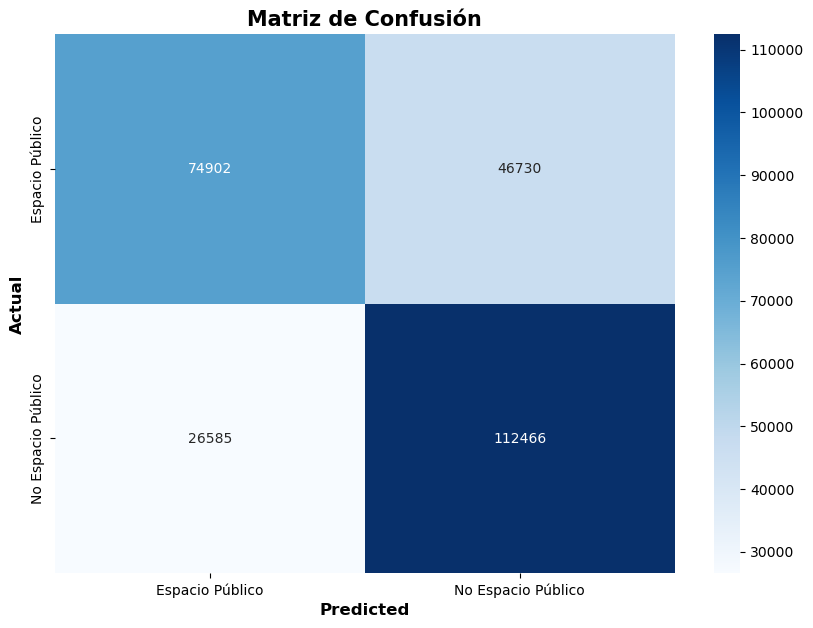

In [43]:
clf = LogisticRegression()
clf.fit(x_train_scale, y_train_clean)

y_pred = clf.predict(x_test_scale)

#Generar matriz de confusión:
cm = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()

In [44]:
accuracy = accuracy_score(y_test_clean, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.718758031785732


In [45]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.62      0.67    121632
           1       0.71      0.81      0.75    139051

    accuracy                           0.72    260683
   macro avg       0.72      0.71      0.71    260683
weighted avg       0.72      0.72      0.72    260683



### Naive Bayes

In [46]:
nb = GaussianNB()
nb.fit(x_train_scale, y_train_clean)

GaussianNB()

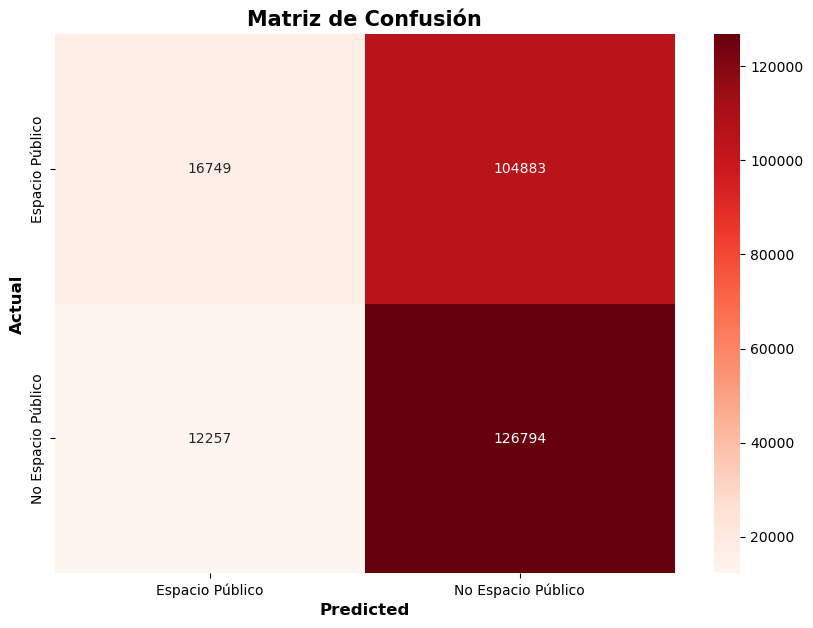

In [47]:
y_prend = nb.predict(x_test_clean)
cm = confusion_matrix(y_test_clean, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [48]:
accuracy = accuracy_score(y_test_clean, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5506419674470525


In [49]:
print(classification_report(y_test_clean, y_prend))

              precision    recall  f1-score   support

           0       0.58      0.14      0.22    121632
           1       0.55      0.91      0.68    139051

    accuracy                           0.55    260683
   macro avg       0.56      0.52      0.45    260683
weighted avg       0.56      0.55      0.47    260683



## Random Forest Classifier (RFC)

In [140]:
rf = RandomForestClassifier(n_estimators=120, random_state=42)  
rf.fit(x_train_scale, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_predd = rf.predict(x_test_clean)

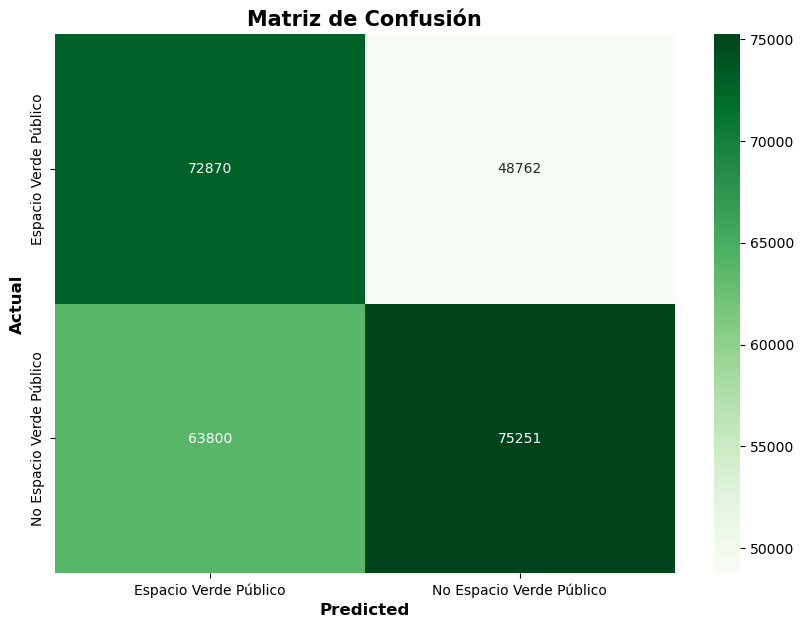

In [141]:
cm = confusion_matrix(y_test_clean, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [142]:
accuracy = accuracy_score(y_test_clean, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5682035268889801


In [53]:
print(classification_report(y_test_clean, y_predd))

              precision    recall  f1-score   support

           0       0.53      0.60      0.56    121632
           1       0.61      0.54      0.57    139051

    accuracy                           0.57    260683
   macro avg       0.57      0.57      0.57    260683
weighted avg       0.57      0.57      0.57    260683



## Ada Boost Classifier

In [54]:
model = AdaBoostClassifier(n_estimators = 1)
model.fit(x_train_scale, y_train_clean)

AdaBoostClassifier(n_estimators=1)

In [55]:
predictions = model.predict(x_test_clean)
predictions

array([1, 1, 1, ..., 1, 1, 1])

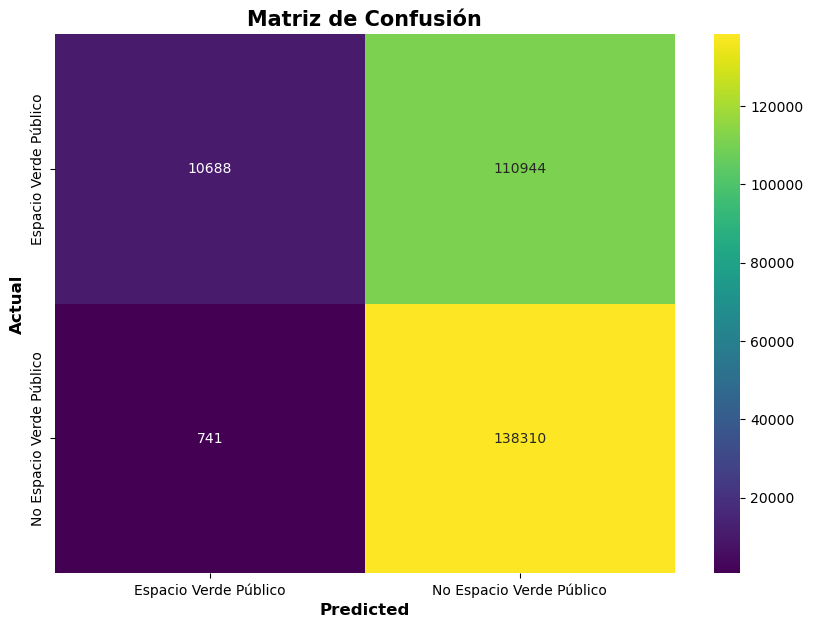

In [56]:
cm = confusion_matrix(y_test_clean, predictions)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [57]:
print(classification_report(y_test_clean, predictions))

              precision    recall  f1-score   support

           0       0.94      0.09      0.16    121632
           1       0.55      0.99      0.71    139051

    accuracy                           0.57    260683
   macro avg       0.75      0.54      0.44    260683
weighted avg       0.73      0.57      0.45    260683



In [58]:
accuracy = accuracy_score(y_test_clean, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5715677662141375


## XGBClassifier

In [59]:
model2 = xgb.XGBClassifier()
model2.fit(x_train_scale, y_train_clean)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:
predictions2 = model2.predict(x_test_clean)
predictions2

array([0, 1, 1, ..., 1, 1, 0])

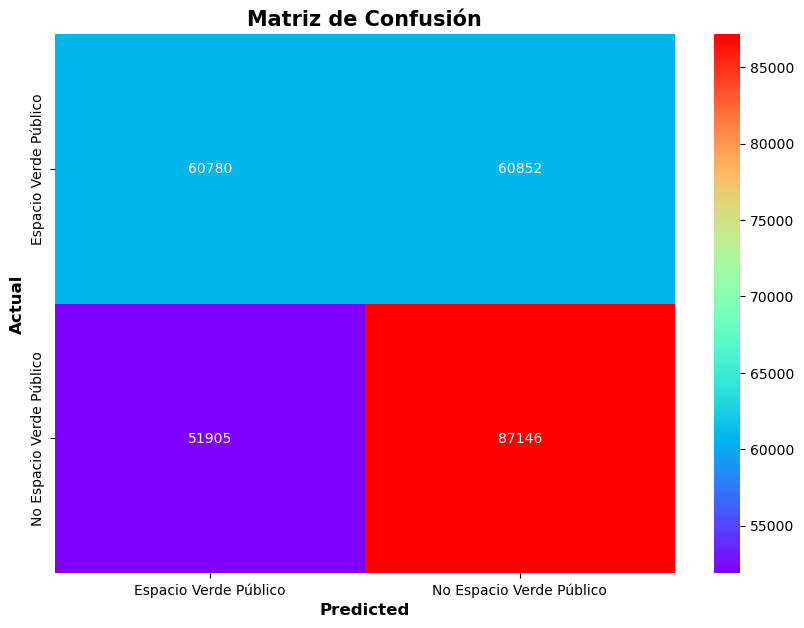

In [61]:
cm = confusion_matrix(y_test_clean, predictions2)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [62]:
print(classification_report(y_test_clean, predictions2))

              precision    recall  f1-score   support

           0       0.54      0.50      0.52    121632
           1       0.59      0.63      0.61    139051

    accuracy                           0.57    260683
   macro avg       0.56      0.56      0.56    260683
weighted avg       0.57      0.57      0.57    260683



In [63]:
accuracy = accuracy_score(y_test_clean, predictions2)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5674554919193043


## Decision Tree Classification

In [64]:
from sklearn.tree import DecisionTreeClassifier

In [65]:
model3 = DecisionTreeClassifier()
model3.fit(x_train_scale, y_train_clean)

DecisionTreeClassifier()

In [66]:
predictions3 = model3.predict(x_test_clean)
predictions3

array([0, 1, 0, ..., 1, 1, 0])

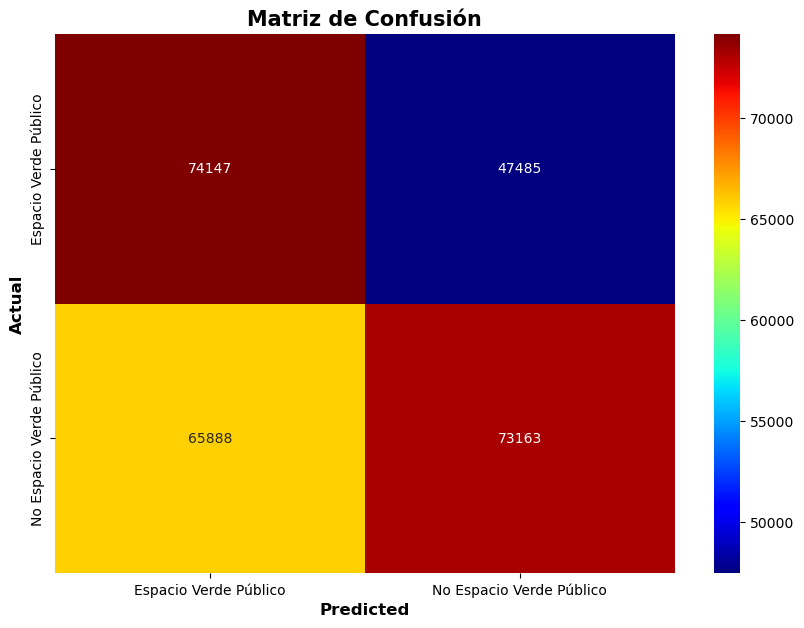

In [67]:
cm = confusion_matrix(y_test_clean, predictions3)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [68]:
print(classification_report(y_test_clean, predictions3))

              precision    recall  f1-score   support

           0       0.53      0.61      0.57    121632
           1       0.61      0.53      0.56    139051

    accuracy                           0.57    260683
   macro avg       0.57      0.57      0.57    260683
weighted avg       0.57      0.57      0.56    260683



In [69]:
accuracy = accuracy_score(y_test_clean, predictions3)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5650924686304822


## Clasificador con población.

In [70]:
'''import psycopg2

# Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

# Ejecutar la consulta para obtener el esquema de la tabla
table_name = 'hex_censo_mza_2020_res9'
cur.execute(f"""
    SELECT table_schema
    FROM information_schema.tables
    WHERE table_name = '{table_name}';
""")

# Obtener los resultados
schema = cur.fetchone()
print(f"El esquema de la tabla {table_name} es: {schema[0]}")

cur.close()
conn.close()'''

El esquema de la tabla hex_censo_mza_2020_res9 es: censo


In [118]:
hex_schema_mza = "censo"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_mza = "hex_censo_mza_2020_res9"
c1 = 'Guadalajara'
c2 = 'CDMX'
n = "9"
t = "urban"

#Consulta para la tabla de población (solo tipo urbano y ciudades seleccionadas):
query_pob = f"""
SELECT * 
FROM {hex_schema_pob}.{hex_table_pob} 
WHERE city IN ('{c1}', '{c2}') 
AND type = '{t}'
"""

hex_gdl_pob = aup.gdf_from_query(query_pob, geometry_col='geometry')
hex_gdl_pob.head(5)

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban
2,89498c97333ffff,"POLYGON ((-103.27379 20.66284, -103.27257 20.6...",14039,Guadalajara,Guadalajara,urban
3,89498c96063ffff,"POLYGON ((-103.33352 20.63689, -103.33230 20.6...",14039,Guadalajara,Guadalajara,urban
4,89498c95cb3ffff,"POLYGON ((-103.29386 20.71601, -103.29264 20.7...",14039,Guadalajara,Guadalajara,urban


In [72]:
import psycopg2

conn = psycopg2.connect(
    host="hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database="postgres",
    user="odc_writer",
    password="writejacobs1918"
)

cur = conn.cursor()

table_name = 'hex_censo_mza_2020_res9'

cur.execute(f"""
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = '{table_name}';
""")

columns = cur.fetchall()
for column in columns:
    print(column[0])

# Cerrar cursor y conexión
cur.close()
conn.close()



phogjef_f
geometry
pobtot
pobfem
pobmas
p_0a2
p_0a2_f
p_0a2_m
p_3ymas
p_3ymas_f
p_3ymas_m
p_5ymas
p_5ymas_f
p_5ymas_m
p_12ymas
p_12ymas_f
p_12ymas_m
p_15ymas
p_15ymas_f
p_15ymas_m
p_18ymas
p_18ymas_f
p_18ymas_m
p_3a5
p_3a5_f
p_3a5_m
p_6a11
p_6a11_f
p_6a11_m
p_8a14
p_8a14_f
p_8a14_m
p_12a14
p_12a14_f
p_12a14_m
p_15a17
p_15a17_f
p_15a17_m
p_18a24
p_18a24_f
p_18a24_m
p_15a49_f
p_60ymas
p_60ymas_f
p_60ymas_m
rel_h_m
pob0_14
pob15_64
pob65_mas
prom_hnv
pnacent
pnacent_f
pnacent_m
pnacoe
pnacoe_f
pnacoe_m
pres2015
pres2015_f
pres2015_m
presoe15
presoe15_f
presoe15_m
p3ym_hli
p3ym_hli_f
p3ym_hli_m
p3hlinhe
p3hlinhe_f
p3hlinhe_m
p3hli_he
p3hli_he_f
p3hli_he_m
p5_hli
p5_hli_nhe
p5_hli_he
phog_ind
pob_afro
pob_afro_f
pob_afro_m
pcon_disc
pcdisc_mot
pcdisc_vis
pcdisc_leng
pcdisc_aud
pcdisc_mot2
pcdisc_men
pcon_limi
pclim_csb
pclim_vis
pclim_haco
pclim_oaud
pclim_mot2
pclim_re_co
pclim_pmen
psind_lim
p3a5_noa
p3a5_noa_f
p3a5_noa_m
p6a11_noa
p6a11_noaf
p6a11_noam
p12a14noa
p12a14noaf
p12a14noam
p15

In [73]:
#Consulta para la tabla de manzanas (solo ciudades seleccionadas):
query_mza = f"""
SELECT hex_id_9, pobtot, geometry
FROM {hex_schema_mza}.{hex_table_mza} 
"""

hex_gdl_mza = aup.gdf_from_query(query_mza, geometry_col='geometry')

In [74]:
pob = hex_gdl_pob.shape
mza = hex_gdl_mza.shape

print(pob)
print(mza)

(13629, 6)
(119059, 3)


In [75]:
hex_gdl_pob['city'].unique()

array(['Guadalajara', 'CDMX'], dtype=object)

In [131]:
hex_schema_mza = "censo"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_mza = "hex_censo_mza_2020_res9"
c1 = 'Guadalajara'
c2 = 'CDMX'
t = "urban"


query_join = f"""
SELECT pob.hex_id_9, pob.city, pob.type, mza.pobtot, mza.geometry
FROM {hex_schema_pob}.{hex_table_pob} pob
INNER JOIN {hex_schema_mza}.{hex_table_mza} mza
ON pob.hex_id_9 = mza.hex_id_9
WHERE pob.city IN ('{c1}', '{c2}') 
AND pob.type = '{t}'
"""

hex_gdl_join = aup.gdf_from_query(query_join, geometry_col='geometry')

hex_gdl_join.head(5)


,hex_id_9,city,type,pobtot,geometry
0,894995b1507ffff,CDMX,urban,1159.0,"POLYGON ((-99.26246 19.38575, -99.26122 19.387..."
1,894995b2277ffff,CDMX,urban,736.0,"POLYGON ((-99.30773 19.34790, -99.30650 19.349..."
2,89499584547ffff,CDMX,urban,1265.0,"POLYGON ((-99.17964 19.28341, -99.17841 19.284..."
3,8949958cc9bffff,CDMX,urban,1717.0,"POLYGON ((-99.04364 19.37460, -99.04240 19.376..."
4,89499585e13ffff,CDMX,urban,3163.0,"POLYGON ((-99.11471 19.32935, -99.11347 19.330..."


In [132]:
contador_gdl_join = np.sum(hex_gdl_join['city'] == 'Guadalajara')
contador_cdmxx_join = np.sum(hex_gdl_join['city'] == 'CDMX')
print(f'Número de hexágonos Gdl: {contador_gdl_join} \nNúmero de hexágonos Cdmx: {contador_cdmxx_join}')

Número de hexágonos Gdl: 5650 
Número de hexágonos Cdmx: 6165


In [133]:
hex_gdl_join = hex_gdl_join.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)

CRS of gdf_gdl: EPSG:4326


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [134]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl_join['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl_join.head()

,hex_id_9,city,type,pobtot,geometry,EspPublico
0,894995b1507ffff,CDMX,urban,1159.0,"POLYGON ((-99.26246 19.38575, -99.26122 19.387...",1
1,894995b2277ffff,CDMX,urban,736.0,"POLYGON ((-99.30773 19.34790, -99.30650 19.349...",0
2,89499584547ffff,CDMX,urban,1265.0,"POLYGON ((-99.17964 19.28341, -99.17841 19.284...",1
3,8949958cc9bffff,CDMX,urban,1717.0,"POLYGON ((-99.04364 19.37460, -99.04240 19.376...",1
4,89499585e13ffff,CDMX,urban,3163.0,"POLYGON ((-99.11471 19.32935, -99.11347 19.330...",1


In [135]:
contador_ceros_join = np.sum(hex_gdl_join['EspPublico'] == 0)
contador_uno_join = np.sum(hex_gdl_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 7364 
Número de Hexágonos con Espacios Públicos: 4451
Número total de Hexágonos: 11815


## Intersección espacial

In [99]:
pd.isna(hex_gdl_join).sum()

hex_id_9           0
city               0
type               0
pobtot             0
geometry           0
poblacion_total    0
dtype: int64

In [121]:
hex_gdl_pob = hex_gdl_pob.set_crs("EPSG:4326")
hex_gdl_mza = hex_gdl_mza.set_crs("EPSG:4326")

In [122]:
inter_join = gpd.sjoin(hex_gdl_pob, hex_gdl_mza, op='intersects')
print(inter_join)

         hex_id_9_left                                           geometry  \
0      89498c96e0bffff  POLYGON ((-103.35267 20.66765, -103.35145 20.6...   
82     89498c96ecfffff  POLYGON ((-103.35003 20.66229, -103.34881 20.6...   
333    89498c96e47ffff  POLYGON ((-103.34935 20.66910, -103.34813 20.6...   
389    89498c96e1bffff  POLYGON ((-103.35301 20.66425, -103.35179 20.6...   
721    89498c96e57ffff  POLYGON ((-103.34969 20.66569, -103.34847 20.6...   
...                ...                                                ...   
13594  894995b96d3ffff  POLYGON ((-99.05118 19.43500, -99.04994 19.436...   
13534  894995b96cfffff  POLYGON ((-99.05030 19.44172, -99.04906 19.443...   
13550  894995b9657ffff  POLYGON ((-99.04985 19.44507, -99.04861 19.446...   
13570  894995b96cbffff  POLYGON ((-99.04746 19.43971, -99.04622 19.441...   
13570  894995b96cbffff  POLYGON ((-99.04746 19.43971, -99.04622 19.441...   

      CVEGEO               NOMGEO         city   type  index_right  \
0    

In [129]:
inter_join.drop(columns=['index_right', 'hex_id_9_right'], inplace=True)
inter_join.rename(columns={"hex_id_9_left": "hex_id_9"}, inplace=True)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
82,89498c96ecfffff,"POLYGON ((-103.35003 20.66229, -103.34881 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
333,89498c96e47ffff,"POLYGON ((-103.34935 20.66910, -103.34813 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
389,89498c96e1bffff,"POLYGON ((-103.35301 20.66425, -103.35179 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
721,89498c96e57ffff,"POLYGON ((-103.34969 20.66569, -103.34847 20.6...",14039,Guadalajara,Guadalajara,urban,975.0


In [136]:
pd.isna(inter_join).sum()

hex_id_9    0
geometry    0
CVEGEO      0
NOMGEO      0
city        0
type        0
pobtot      0
dtype: int64

In [143]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = inter_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

inter_join['EspPublico'] = intersects_public_spaces.astype(int)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot,EspPublico
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
82,89498c96ecfffff,"POLYGON ((-103.35003 20.66229, -103.34881 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
333,89498c96e47ffff,"POLYGON ((-103.34935 20.66910, -103.34813 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
389,89498c96e1bffff,"POLYGON ((-103.35301 20.66425, -103.35179 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
721,89498c96e57ffff,"POLYGON ((-103.34969 20.66569, -103.34847 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0


In [150]:
cont_ceros_join = np.sum(hex_gdl_pob['EspPublico'] == 0)
cont_uno_join = np.sum(hex_gdl_pob['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros_interj} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno_interj}\nNúmero total de Hexágonos: {cont_ceros_interj + cont_uno_interj}')

Números de hexagonos sin Espacios Públicos: 49764 
Número de Hexágonos con Espacios Públicos: 30868
Número total de Hexágonos: 80632


## Submuestreo población

In [146]:
num_samples_join = len(inter_join[inter_join['EspPublico'] == 1])

# Randomly sample 80632 hexagons with public spaces
sample_with_public_spaces_join = inter_join[inter_join['EspPublico'] == 1].sample(n=num_samples_join, random_state=42)

# Randomly sample 80632 hexagons without public spaces
sample_without_public_spaces_join = inter_join[inter_join['EspPublico'] == 0].sample(n=num_samples_join, random_state=42)

# Concatenate the two samples to get the final subsample
inter_join = pd.concat([sample_with_public_spaces_join, sample_without_public_spaces_join])
inter_join.reset_index(drop = True, inplace = True)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot,EspPublico
0,8949958518bffff,"POLYGON ((-99.11824 19.30248, -99.11700 19.304...",09003,Coyoacán,CDMX,urban,1007.0,1
1,89499585b53ffff,"POLYGON ((-99.12210 19.36758, -99.12086 19.369...",09007,Iztapalapa,CDMX,urban,2065.0,1
2,89499585287ffff,"POLYGON ((-99.08155 19.29861, -99.08031 19.300...",09007,Iztapalapa,CDMX,urban,1755.0,1
3,8949958eb2fffff,"POLYGON ((-99.07006 19.38592, -99.06882 19.387...",09006,Iztacalco,CDMX,urban,3394.0,1
4,8949958455bffff,"POLYGON ((-99.17397 19.27941, -99.17273 19.280...",09012,Tlalpan,CDMX,urban,1429.0,1


In [151]:
contador_ceros_join = np.sum(inter_join['EspPublico'] == 0)
contador_uno_join = np.sum(inter_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 30868 
Número de Hexágonos con Espacios Públicos: 30868
Número total de Hexágonos: 61736


In [149]:
inter_join.shape

(61736, 8)

## Clasificadores con población

In [152]:
inter_join.drop(columns=['NOMGEO', 'CVEGEO'], inplace=True)

In [155]:
xx = inter_join[["pobtot"]]
yy = inter_join['EspPublico']

In [156]:
yy.unique()

array([1, 0])

## Logistic Regression

In [157]:
# Suponiendo que x y y ya están definidos
x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.2, random_state=42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  # Asegúrate de que 'target' sea el nombre de tu columna objetivo

# Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

# Ahora separa de nuevo x_train y y_train
x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

# Hacer lo mismo para el conjunto de prueba
test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

# Asegurarte de que el conjunto de prueba no tenga NaN
x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

# Escalar los datos
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)

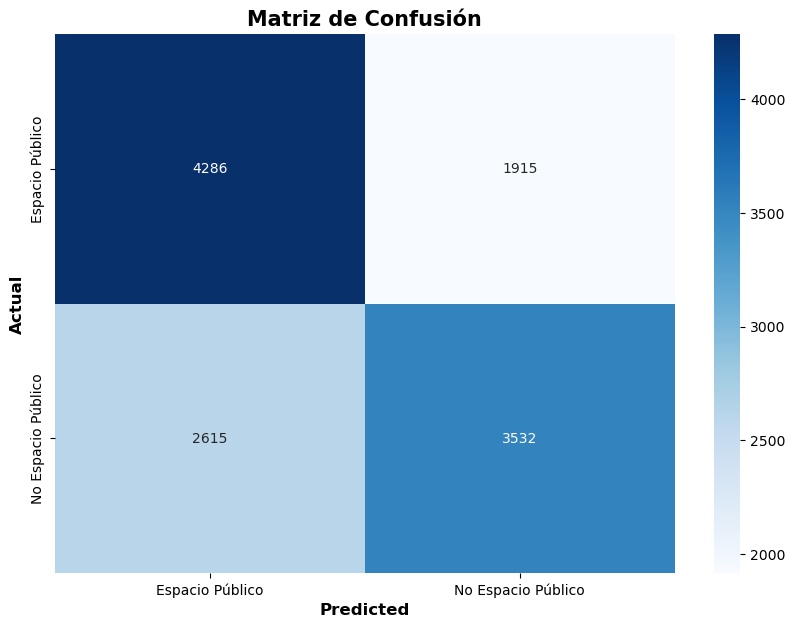

In [158]:
clf2 = LogisticRegression()
clf2.fit(x_train_scale, y_train_clean)

y_pred = clf2.predict(x_test_scale)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()

In [159]:
accuracy = accuracy_score(y_test_clean, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6331389698736638


In [160]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65      6201
           1       0.65      0.57      0.61      6147

    accuracy                           0.63     12348
   macro avg       0.63      0.63      0.63     12348
weighted avg       0.63      0.63      0.63     12348



## Naive Bayes

In [161]:
nb2 = GaussianNB()
nb2.fit(x_train_scale, y_train_clean)

GaussianNB()

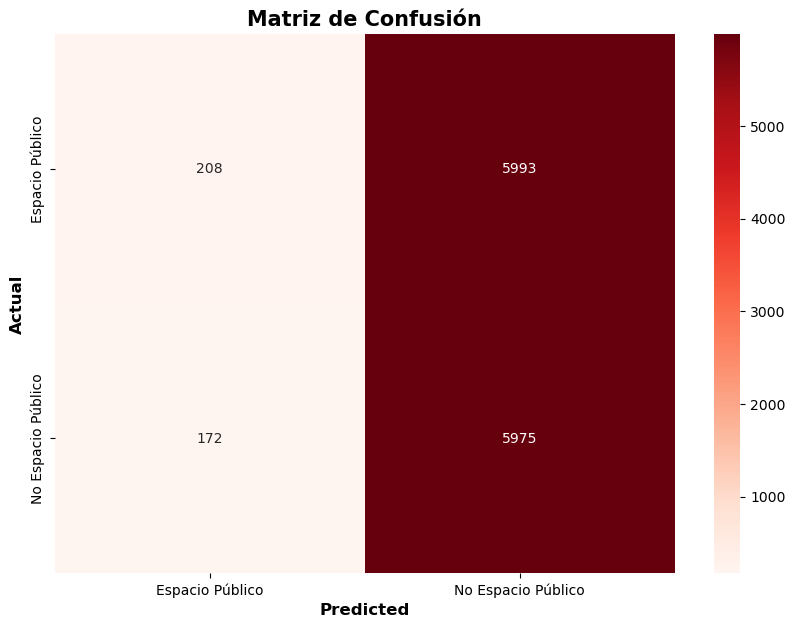

In [162]:
y_prend = nb2.predict(x_test_clean)
cm2 = confusion_matrix(y_test_clean, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [163]:
accuracy = accuracy_score(y_test_clean, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.500728862973761


In [164]:
print(classification_report(y_test_clean, y_prend))

              precision    recall  f1-score   support

           0       0.55      0.03      0.06      6201
           1       0.50      0.97      0.66      6147

    accuracy                           0.50     12348
   macro avg       0.52      0.50      0.36     12348
weighted avg       0.52      0.50      0.36     12348



## Random Forest Classifier (RFC)

In [165]:
rf2 = RandomForestClassifier(n_estimators=120, random_state=42)  
rf2.fit(x_train_scale, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_predd = rf2.predict(x_test_clean)

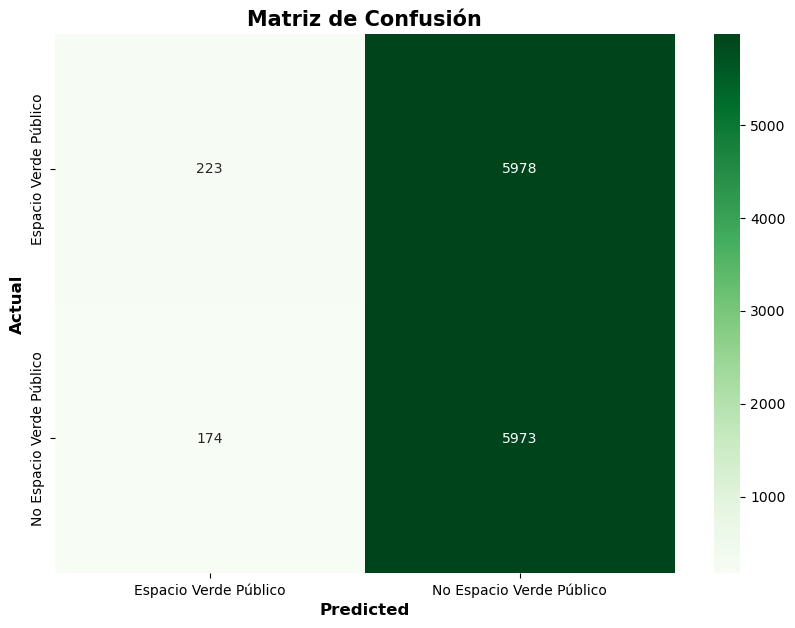

In [166]:
cm2 = confusion_matrix(y_test_clean, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [167]:
accuracy = accuracy_score(y_test_clean, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5017816650469712


In [168]:
print(classification_report(y_test_clean, y_predd))

              precision    recall  f1-score   support

           0       0.56      0.04      0.07      6201
           1       0.50      0.97      0.66      6147

    accuracy                           0.50     12348
   macro avg       0.53      0.50      0.36     12348
weighted avg       0.53      0.50      0.36     12348



## Ada Boost Classifier

In [175]:
model2 = AdaBoostClassifier(n_estimators = 100)
model2.fit(x_train_scale, y_train_clean)

AdaBoostClassifier(n_estimators=100)

In [176]:
predictions2 = model2.predict(x_test_clean)
predictions2

array([1, 1, 1, ..., 1, 1, 1])

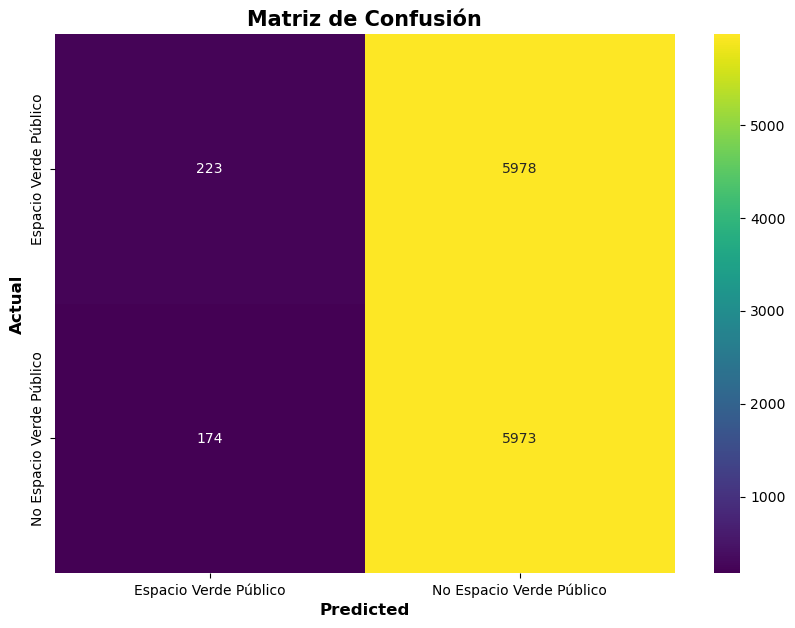

In [177]:
cm2 = confusion_matrix(y_test_clean, predictions2)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [178]:
print(classification_report(y_test_clean, predictions2))

              precision    recall  f1-score   support

           0       0.56      0.04      0.07      6201
           1       0.50      0.97      0.66      6147

    accuracy                           0.50     12348
   macro avg       0.53      0.50      0.36     12348
weighted avg       0.53      0.50      0.36     12348



In [179]:
accuracy = accuracy_score(y_test_clean, predictions2)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5017816650469712


## XGBClassifier

In [174]:
model22 = xgb.XGBClassifier()
model22.fit(x_train_scale, y_train_clean)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [180]:
predictions22 = model22.predict(x_test_clean)
predictions22

array([1, 1, 1, ..., 1, 1, 1])

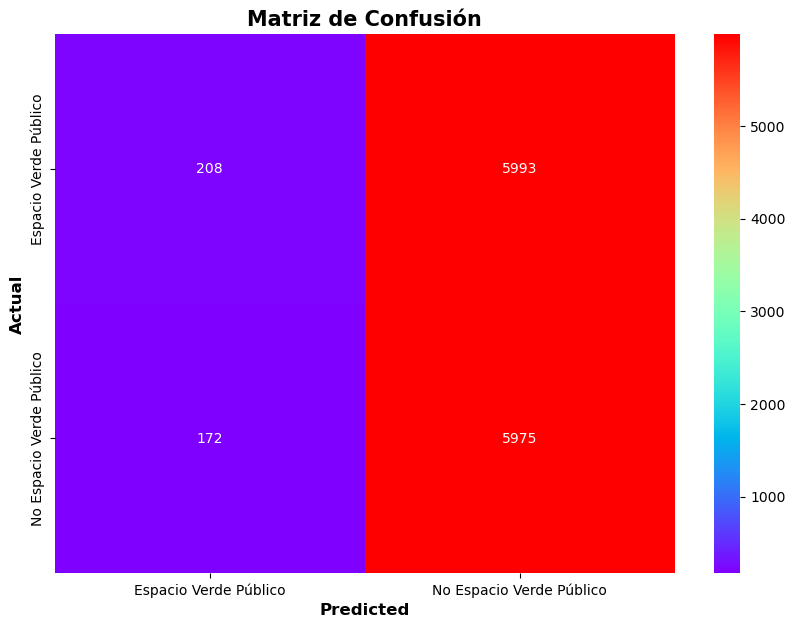

In [181]:
cm2 = confusion_matrix(y_test_clean, predictions22)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [182]:
print(classification_report(y_test_clean, predictions22))

              precision    recall  f1-score   support

           0       0.55      0.03      0.06      6201
           1       0.50      0.97      0.66      6147

    accuracy                           0.50     12348
   macro avg       0.52      0.50      0.36     12348
weighted avg       0.52      0.50      0.36     12348



In [183]:
accuracy = accuracy_score(y_test_clean, predictions22)
print(f'Accuracy: {accuracy}')

Accuracy: 0.500728862973761


## Decision Tree Classification

In [184]:
model32 = DecisionTreeClassifier()
model32.fit(x_train_scale, y_train_clean)

DecisionTreeClassifier()

In [185]:
predictions32 = model32.predict(x_test_clean)
predictions32

array([1, 1, 1, ..., 1, 1, 1])

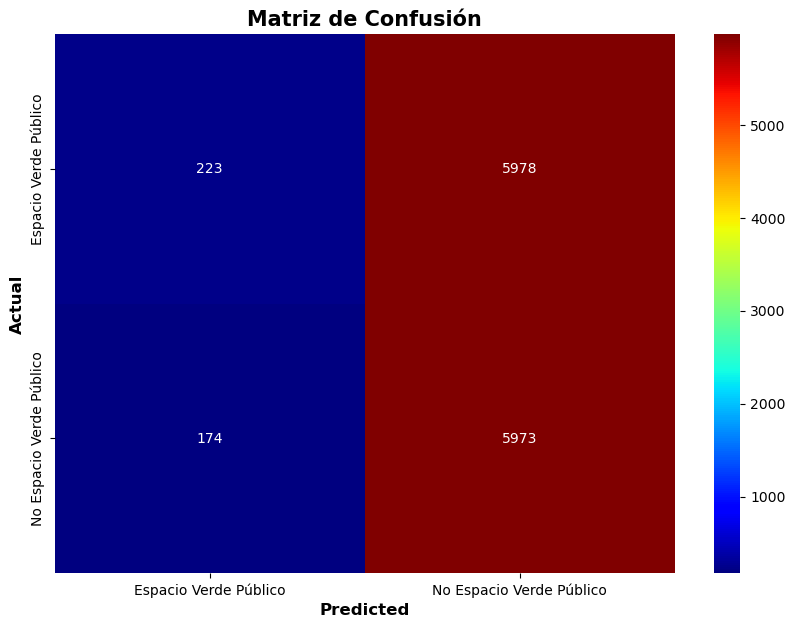

In [186]:
cm2 = confusion_matrix(y_test_clean, predictions32)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [187]:
print(classification_report(y_test_clean, predictions32))

              precision    recall  f1-score   support

           0       0.56      0.04      0.07      6201
           1       0.50      0.97      0.66      6147

    accuracy                           0.50     12348
   macro avg       0.53      0.50      0.36     12348
weighted avg       0.53      0.50      0.36     12348



In [188]:
accuracy = accuracy_score(y_test_clean, predictions32)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5017816650469712


## Intersección espacial con población, vegetación, humedad y temperatura.